### <font color=green>Multiclass Classification of wine quality </font>
![](glasses.png)

### <font color=green>EDA</font>

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the date for red and white wine and merge them
red_wine = pd.read_csv("winequality-red.csv", sep=";")
white_wine = pd.read_csv("winequality-white.csv", sep=";")
red_wine.insert(0, "type", 1)
white_wine.insert(0, "type", 0)
wine = red_wine.append(white_wine, ignore_index=True)

In [3]:
# check dimensions of the data
wine.shape

(6497, 13)

In [4]:
# check the presence of NaNs
wine.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
# display statistics of the data
pd.options.display.float_format = '{:.2f}'.format                   # display two digital places
wine.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00,6497.00
mean,0.25,7.22,0.34,0.32,5.44,0.06,30.53,115.74,0.99,3.22,0.53,10.49,5.82
std,0.43,1.30,0.16,0.15,4.76,0.04,17.75,56.52,0.00,0.16,0.15,1.19,0.87
min,0.00,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,3.00
25%,0.00,6.40,0.23,0.25,1.80,0.04,17.00,77.00,0.99,3.11,0.43,9.50,5.00
50%,0.00,7.00,0.29,0.31,3.00,0.05,29.00,118.00,0.99,3.21,0.51,10.30,6.00
75%,0.00,7.70,0.40,0.39,8.10,0.07,41.00,156.00,1.00,3.32,0.60,11.30,6.00
max,1.00,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,9.00


<font color=blue>No values are missing in the data set and the range of values is realistic.</font>

## <font color=green>Features distribution</font>

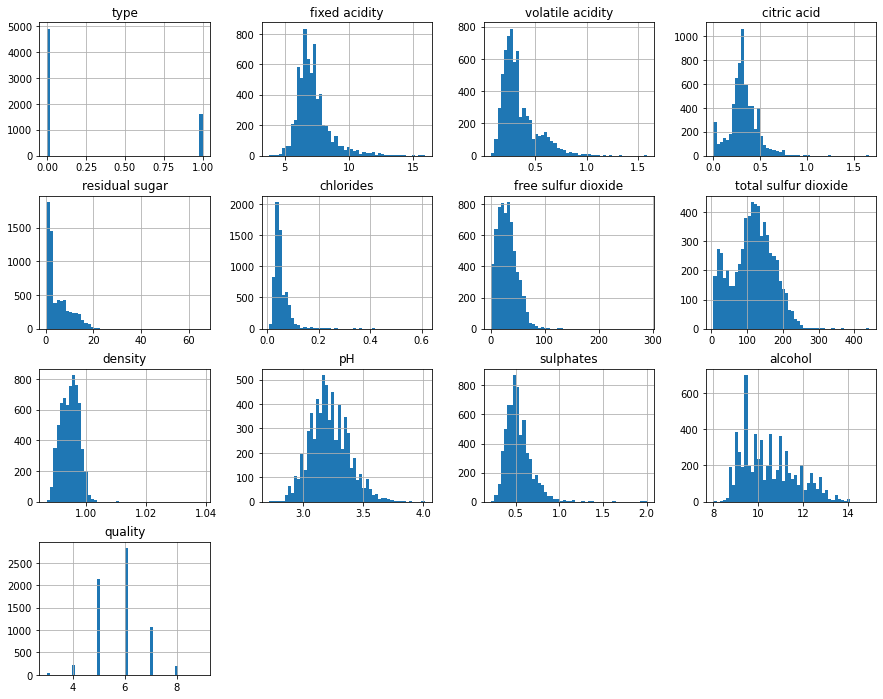

In [6]:
#  features distribution
wine.hist(bins=50, figsize=(15,12));

<font color=blue>**pH** is normally distributed. Most of the other features have a skewed normal distribution, and both  residual sugar and chlorides are heavily skewed to the left </font>

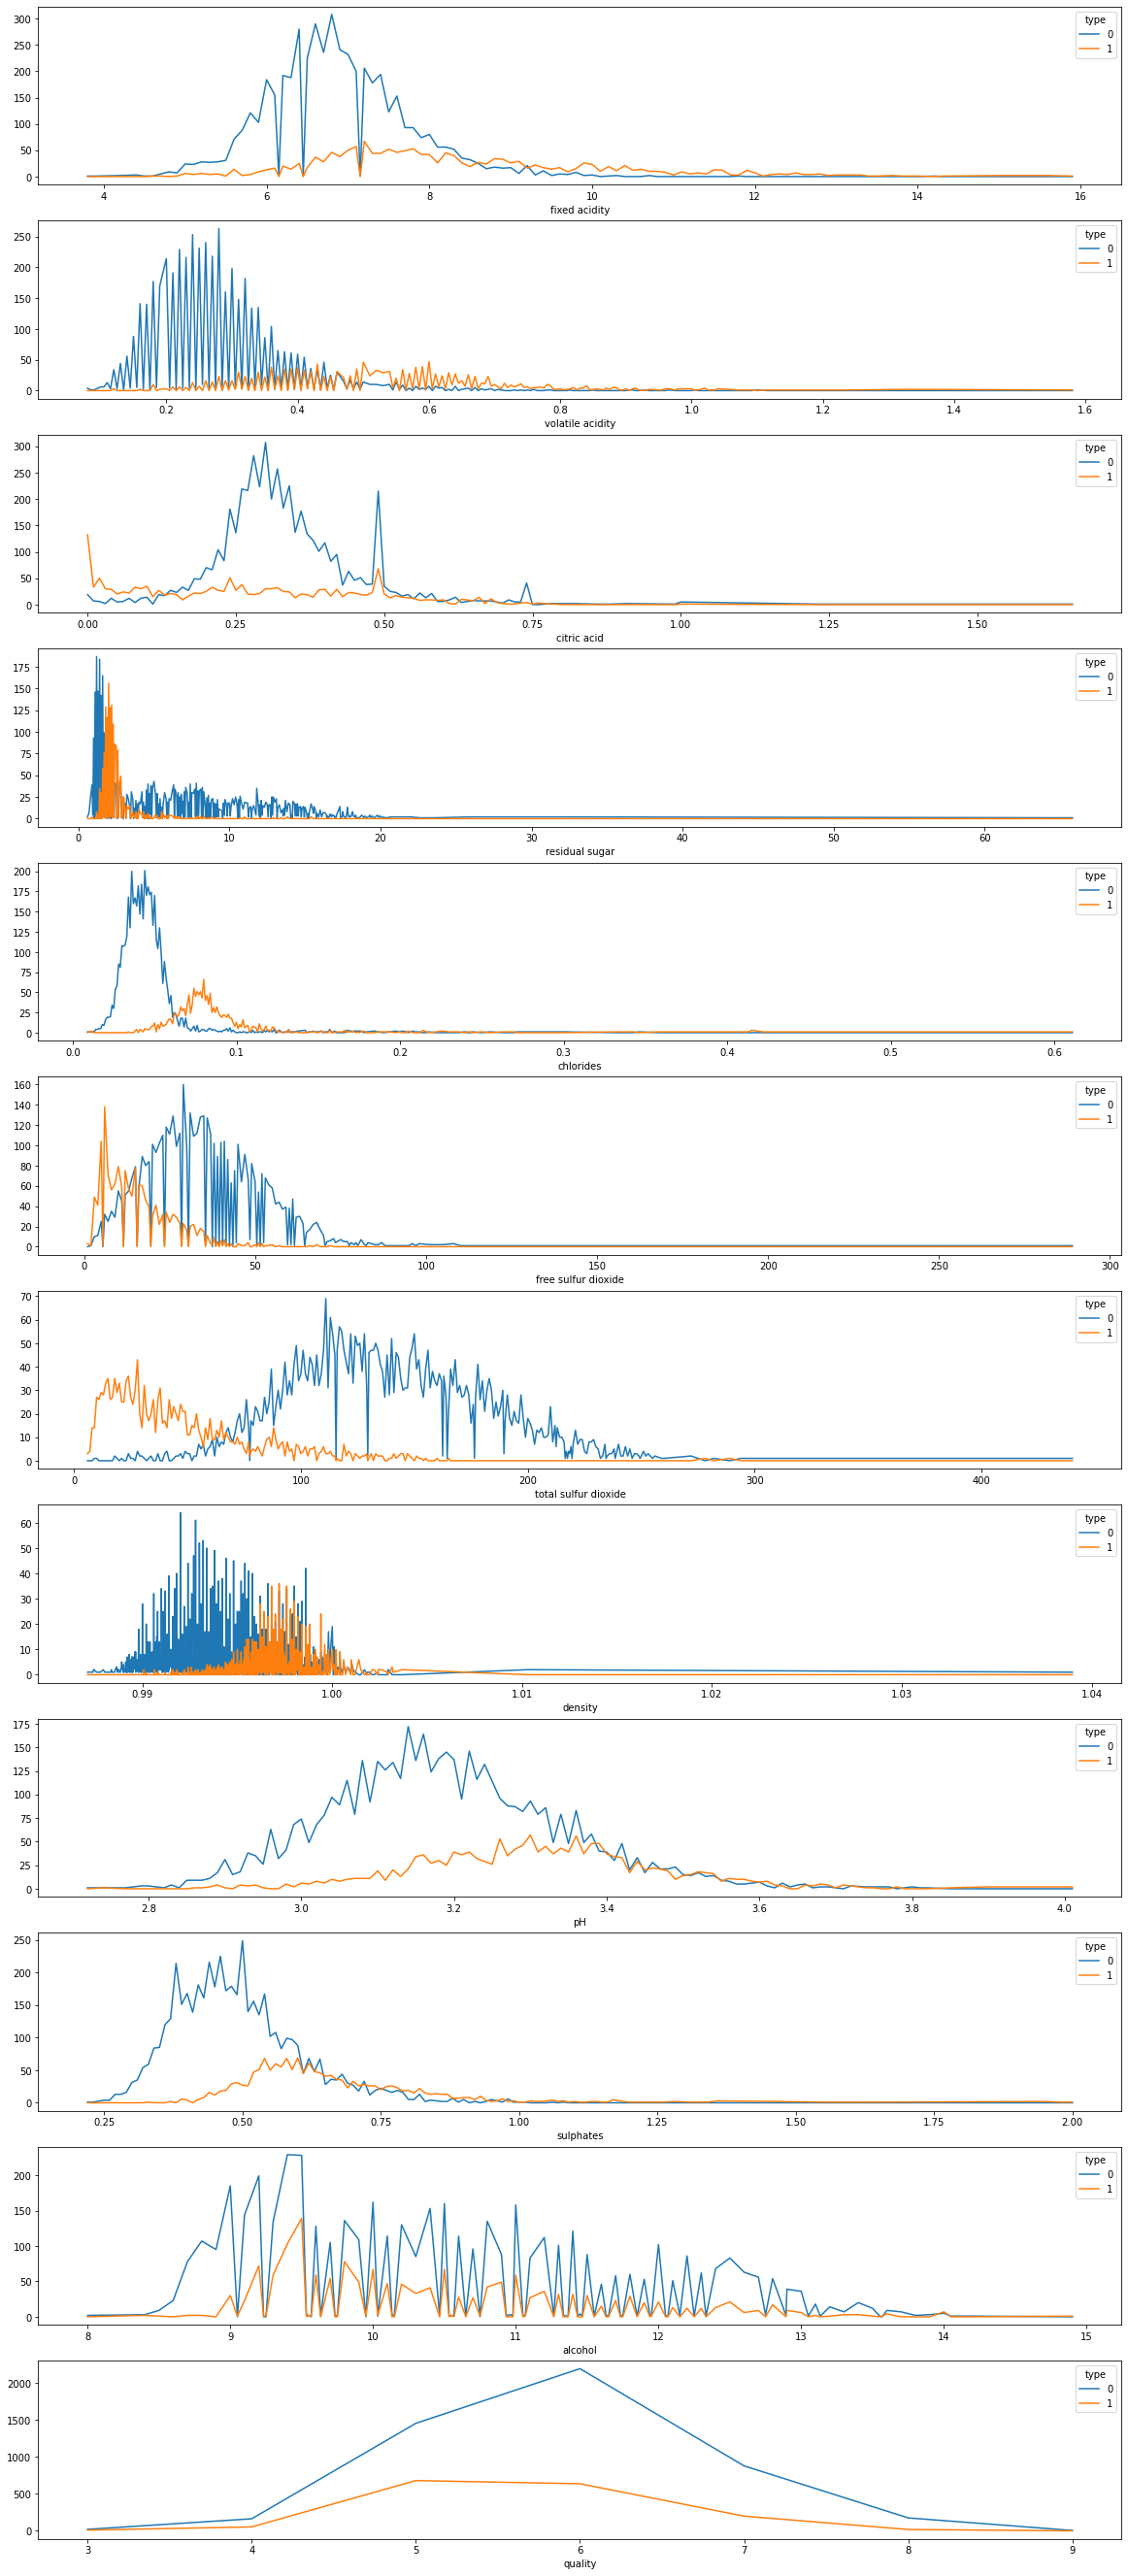

In [7]:
# Feature distribution as function of wine-type
fig, ax = plt.subplots(nrows=12,figsize=[20,48])
wine_features_names=['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
                     'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']
for i in range(1,wine.shape[1]):
    pd.crosstab(index= wine[wine_features_names[i]], columns=wine[wine_features_names[0]]).plot(ax=ax[i-1]);

<font color=blue>There are a few outlier. Some of them will be deleted after splitting the data.</font>

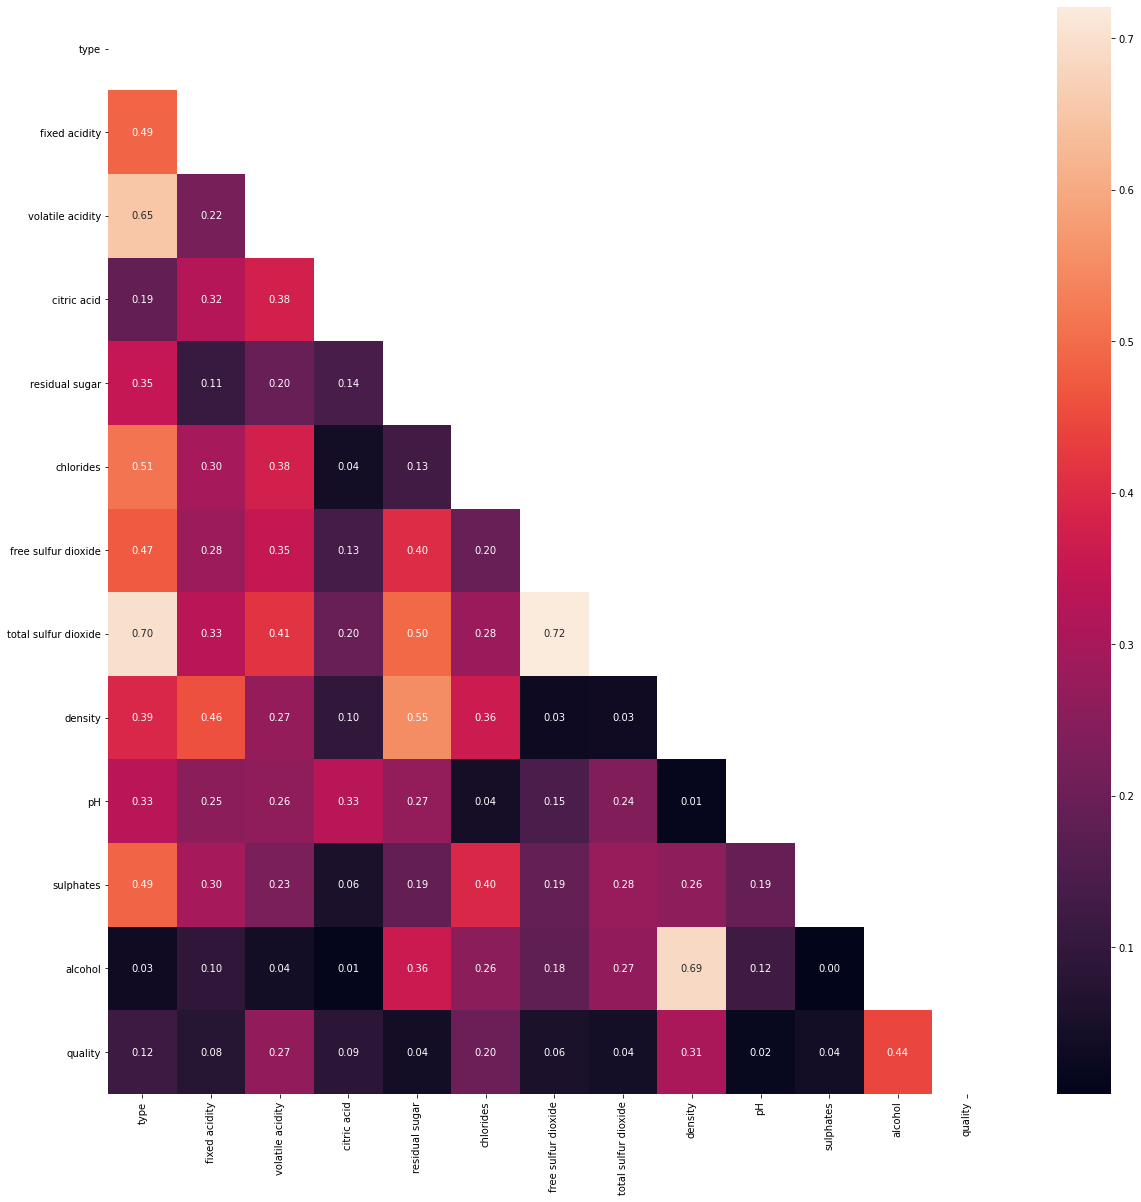

In [8]:
# investigate correlation between features
fig, ax = plt.subplots(figsize=[20,20])
corr= wine.corr()
triangle = np.triu(corr)
sns.heatmap(corr.abs(), annot=True, fmt='.2f', mask=triangle,ax=ax);

<font color=blue>There is a correlation between some features, but it is not very strong.</font>

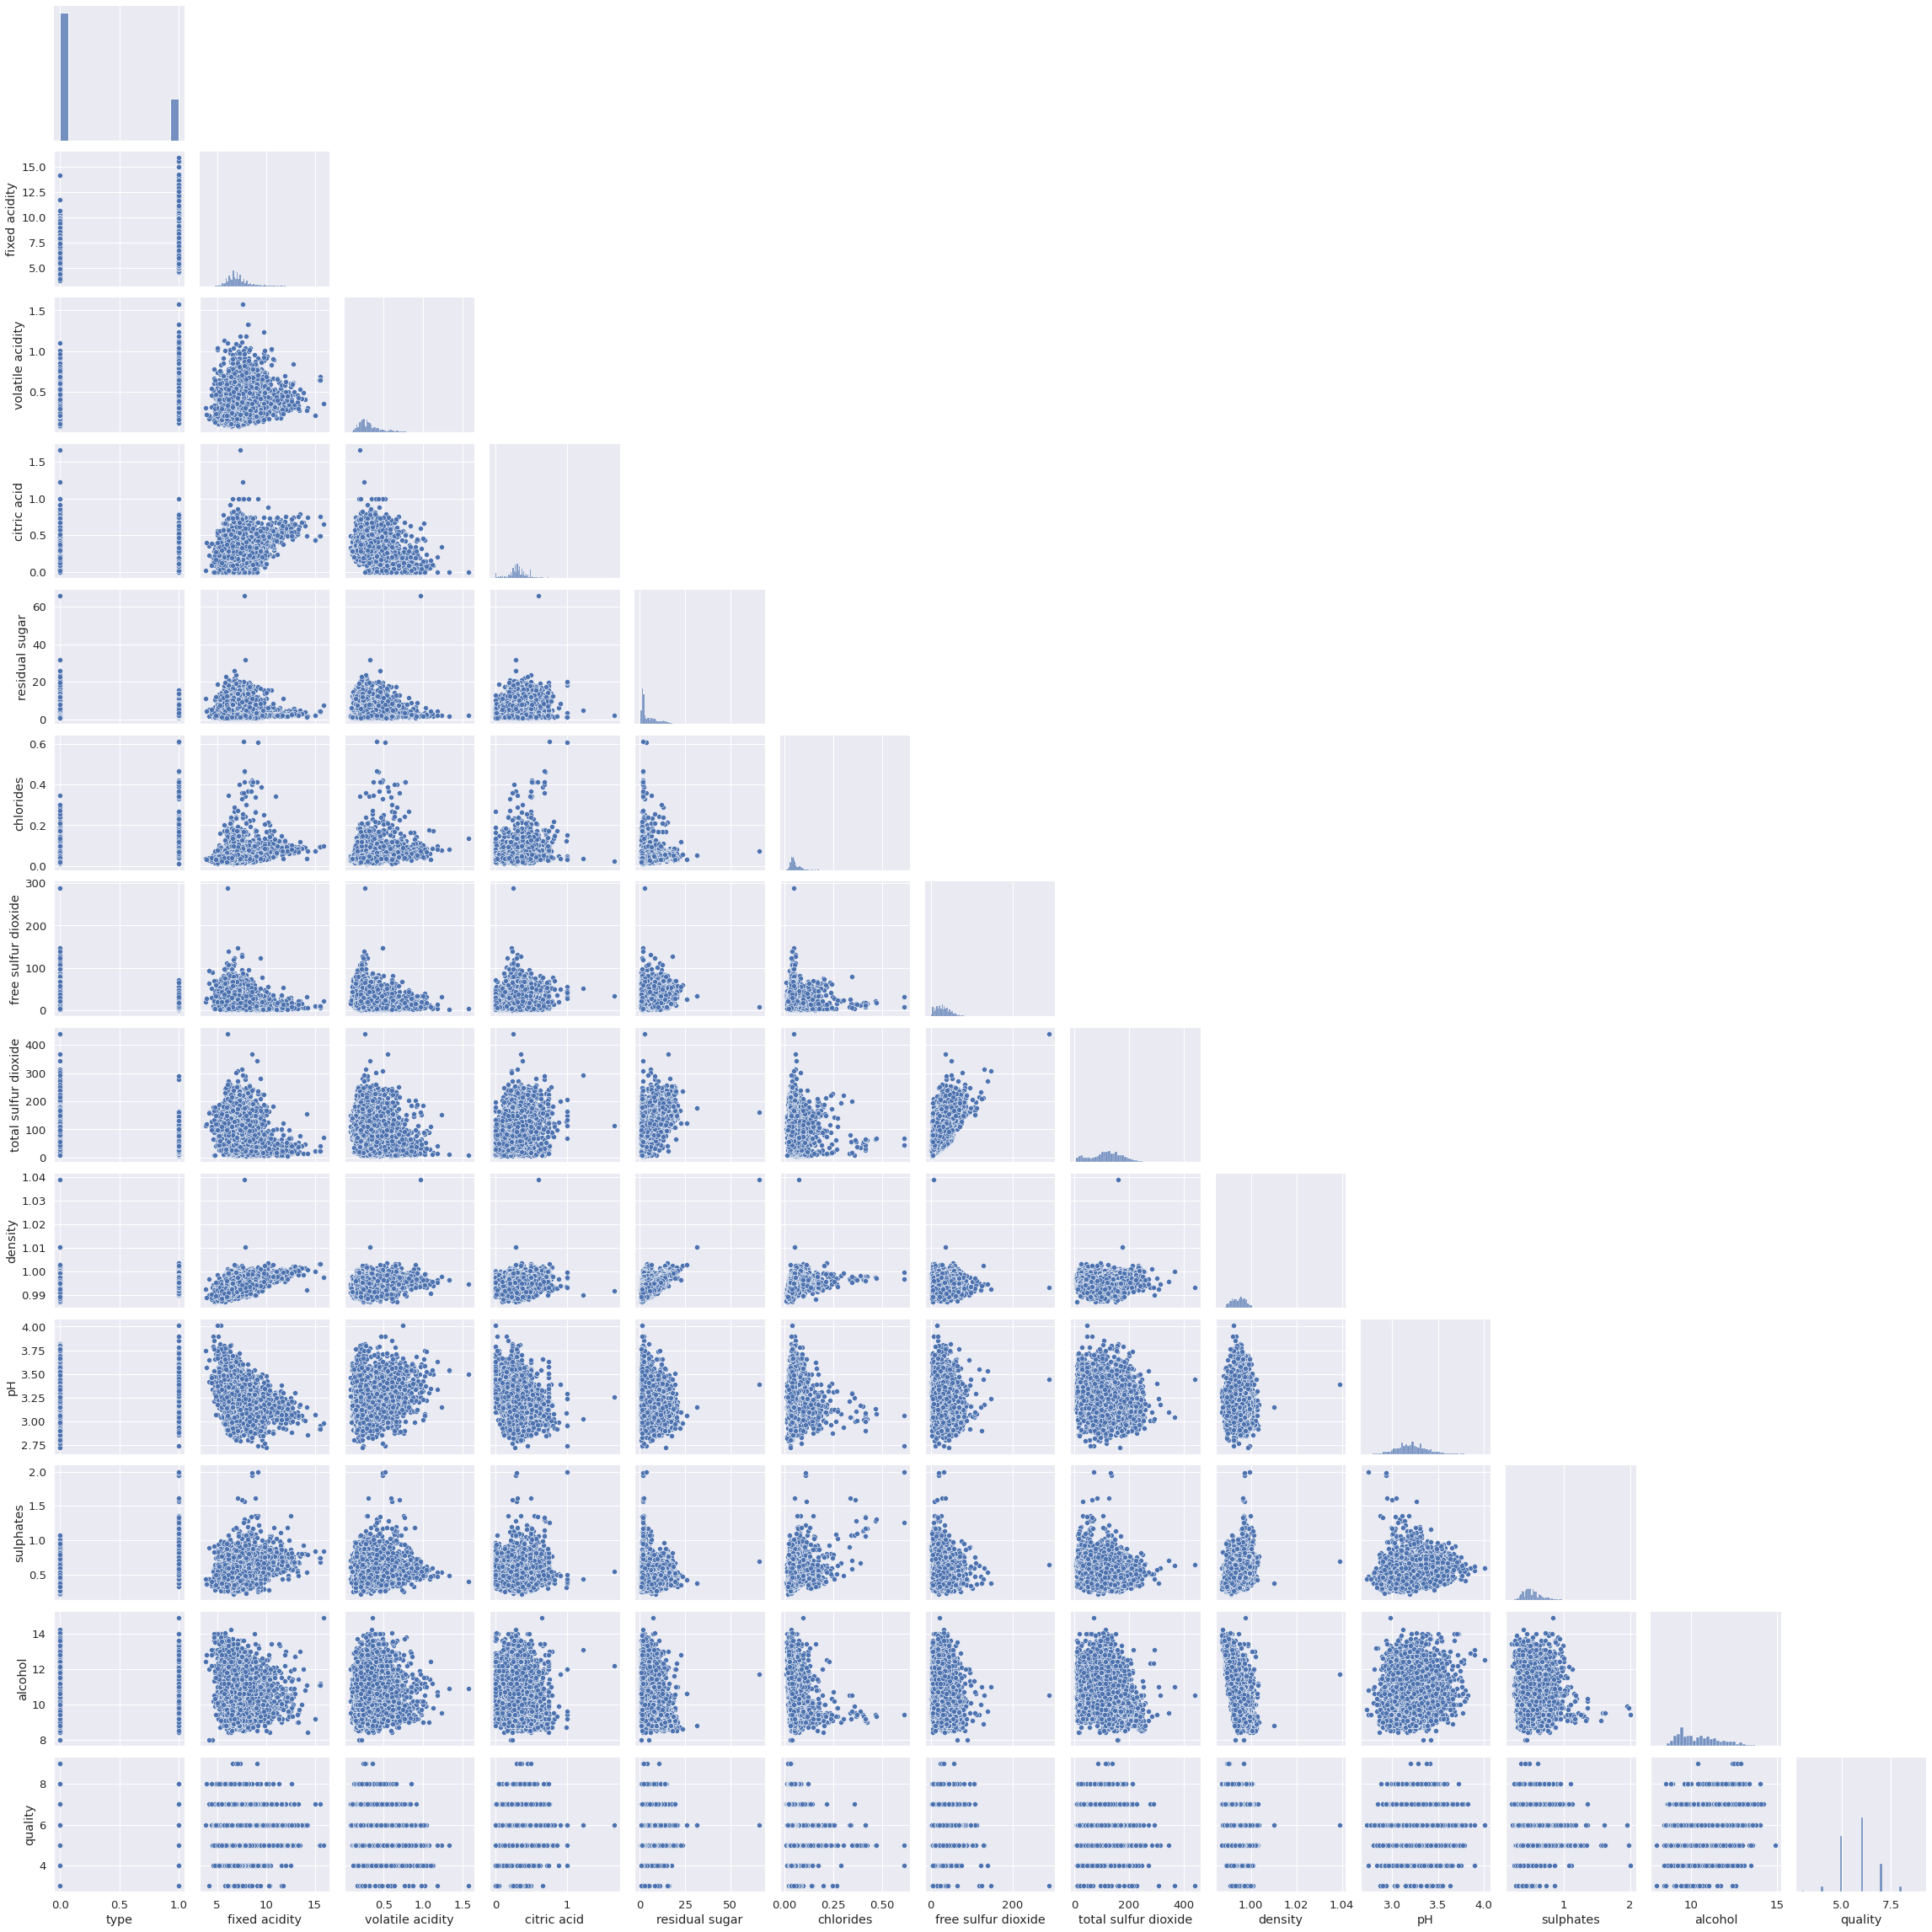

In [9]:
sns.set(font_scale=1.2)
sns.pairplot(wine,corner=True);

In [10]:
# Data distribution per classes
wine["quality"].value_counts(normalize=True) * 100

6   43.65
5   32.91
7   16.61
4    3.32
8    2.97
3    0.46
9    0.08
Name: quality, dtype: float64

<font color=blue>significantly unbalanced. Most instances (76%) have scores of 6 or 5.</font>

### <font color=green>Data preparing</font>

In [11]:
# separate between features and target
wine_features=wine.iloc[:,:-1]
wine_target=wine.iloc[:,-1]

In [12]:
# Train-test data Splitting
w_train_f, w_test_f, w_train_t, w_test_t = train_test_split(wine_features, wine_target, random_state=42, test_size=0.1)

#### <font color=blueviolet>dealing with outliers in training data</font>

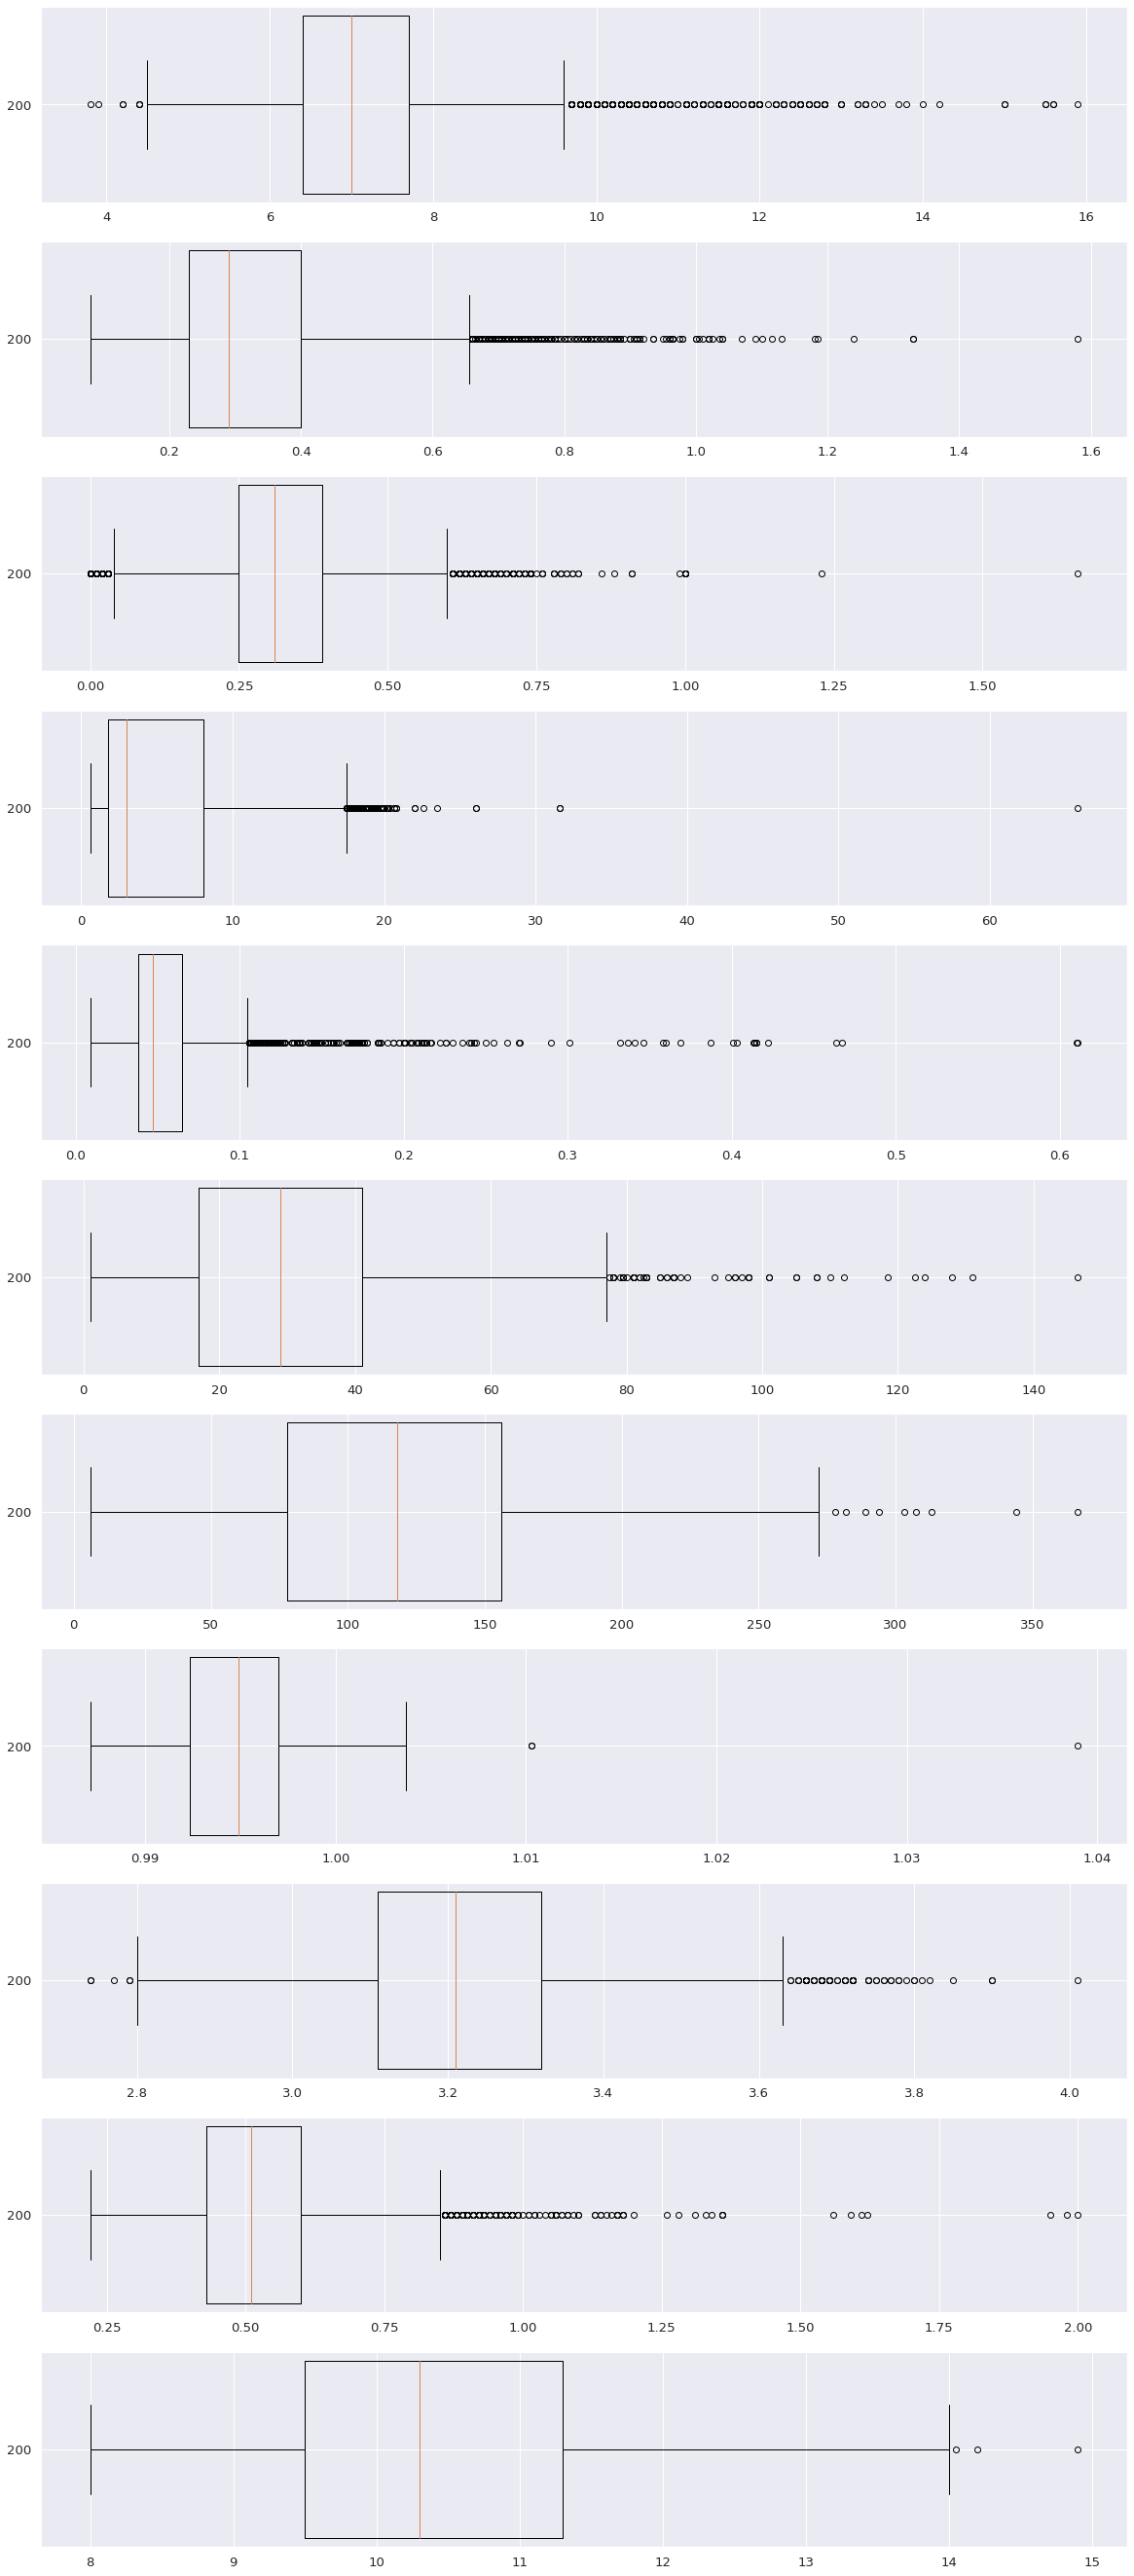

In [13]:
# detecting outlier
wine_outlier=['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
                     'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
fig, ax = plt.subplots(nrows=11,figsize=[20,48])
for i in range(len(wine_outlier)):
    ax[i].boxplot(w_train_f[wine_outlier[i]],vert=False, positions=[200],widths=50);

In [14]:
# remove extreme outlier
threshold=[15,15,1,40,0.5,120,350,1.02,3.9,1.5,14.5]
for i in range(len(wine_outlier)):
    mask_outlier=(w_train_f[wine_outlier[i]]>threshold[i])
    w_train_f=w_train_f.drop(w_train_f.index[mask_outlier])
    w_train_t=w_train_t[w_train_f.index]

### <font color=green>baseline model</font>

In [15]:
# features scaling
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(w_train_f)
features_test_scaled = scaler.transform(w_test_f)
features_train_scaled = pd.DataFrame(features_train_scaled,columns=w_train_f.columns)
features_test_scaled = pd.DataFrame(features_test_scaled,columns=w_test_f.columns)

In [16]:
# LogisticRegression
model_log=LogisticRegression(class_weight='balanced',multi_class='multinomial',random_state=42)
model_log.fit(features_train_scaled,w_train_t)
target_pred=model_log.predict(features_test_scaled)
accuracy_score(w_test_t,target_pred)

f1=f1_score(w_test_t,target_pred,average='weighted')
recall=recall_score(w_test_t,target_pred,average='weighted')
precision=precision_score(w_test_t,target_pred,average='weighted')
print(f1,recall,precision)

0.34731629462563934 0.3076923076923077 0.507831898510137


In [22]:
# RandomForestClassifier
model_rf=RandomForestClassifier(n_estimators=100,max_depth=12,class_weight='balanced',random_state=42)
model_rf.fit(w_train_f,w_train_t)
target_pred=model_rf.predict(w_test_f)
f1=f1_score(w_test_t,target_pred,average='weighted')
recall=recall_score(w_test_t,target_pred,average='weighted')
precision=precision_score(w_test_t,target_pred,average='weighted')
print(f1,recall,precision)

0.6212050349865573 0.6261538461538462 0.6347821227741589
